# Advanced Lane Finding Project

#### Starting the project steps...

In [1]:
#all includes
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

### Camera Calibration Requirements

**Criterea**
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

**Specifications**
OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

**Implementation**
The calibration images are processed by converting the images to grayscale, then finding the chessboard corners, and saving the corners points to the array of points in image plane.
Then, the function cv2.calibrateCamera is called which calculates the matrix and the distortion coefficients to undistort any image taken with the same camera.

Text(0.5,1,'Undistorted Image')

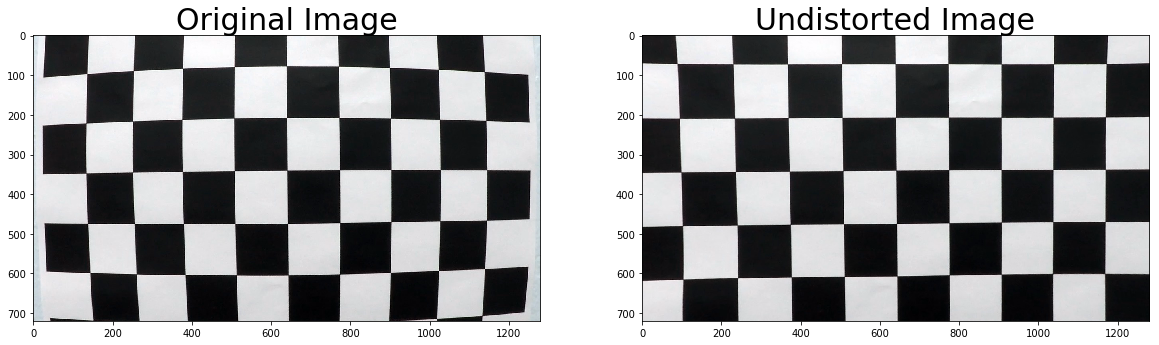

In [2]:
### Calibrate camera function, 
### which returns the calibration matrix and distortion coefficients
def calibrate_camera():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    img_size = (0,0)
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img_size = (img.shape[1], img.shape[0])
        
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return mtx, dist

mtx, dist = calibrate_camera()

#Example test image for one of the calibration images for undistortion
test_img = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg', undist)

# draw the original image and undistorted image from calibration images
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

### Pipeline Steps
#### 1. Distortion-Corrected Image

**Criteria**
Provide an example of a distortion-corrected image.

**Specifications**
Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.

**Implementation**
Having the matrix and distortion coefficients of the camera, any input image can be undistorted using the cv2.undistort function. This works on colored or grayscaled images. In our project, the undistortion step is performed on the original colored image.

Text(0.5,1,'Undistorted Image')

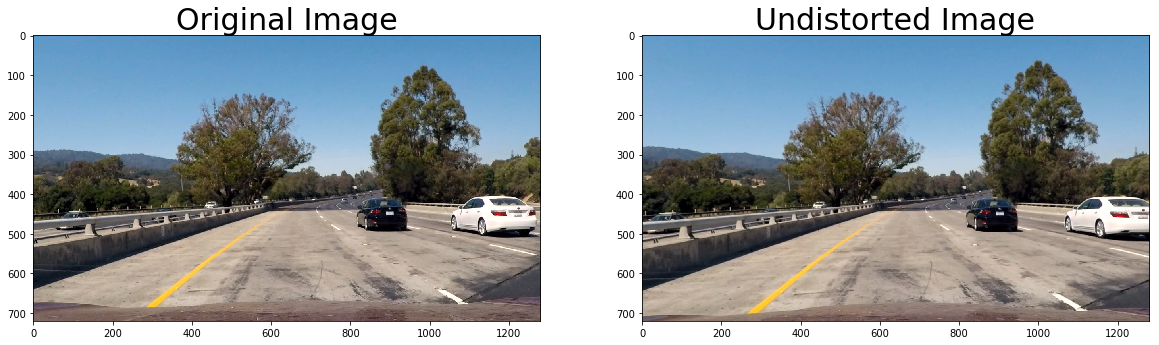

In [60]:
### Undistort image, and save result image in the given path
### returns and saves the undistorted image
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def undistort_image(input_image, output_filename, mtx, dist):
    undist = cv2.undistort(input_image, mtx, dist, None, mtx)
    cv2.imwrite(output_filename, bgr2rgb(undist))
    return undist

### This is the file name which will be used for further processing
fname = "test1"
test_img = mpimg.imread('test_images/'+fname+'.jpg')
#test_img = cv2.imread('test_images/test1.jpg')
undist_img = undistort_image(test_img, 'output_images/'+fname+'_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/test2.jpg'), 'output_images/test2_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/test3.jpg'), 'output_images/test3_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/test4.jpg'), 'output_images/test4_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/test5.jpg'), 'output_images/test5_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/test6.jpg'), 'output_images/test6_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/straight_lines1.jpg'), 'output_images/straight_lines1_undist.jpg', mtx, dist)
#undistort_image(cv2.imread('test_images/straight_lines2.jpg'), 'output_images/straight_lines2_undist.jpg', mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

#### 2. Gradient and Color Transformations
**Criteria**
Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

**Specifications**
A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

**Implementation**
This is a function which transforms the original undistorted image to a binary image using some filters. In the project, I used the color gradients HLS to have filtered output not depending on shades or yellow/white lanes. Then, I applied the sobel transformation for the lightness and saturation color components separately. At the end, the final combined binary image mixes the results of those thresholds to form the final binary image which is ready for the next steps.

Text(0.5,1,'Binary Image')

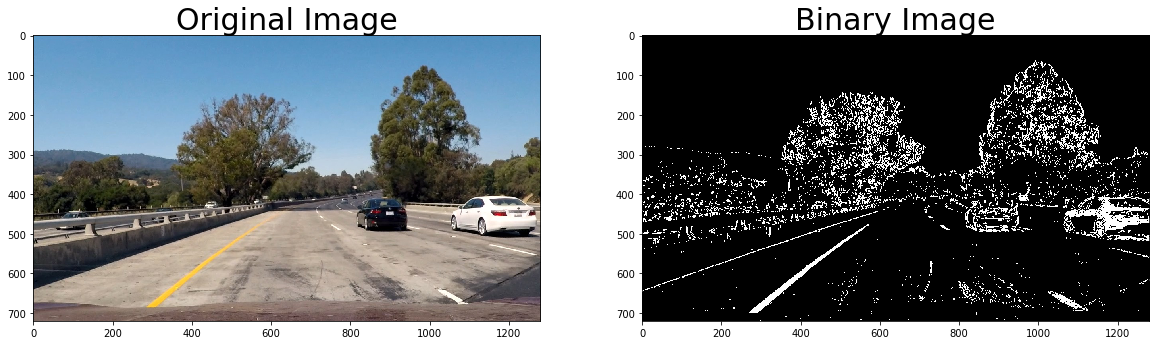

In [61]:
### Function to transform the image to binary image
def transform_img_to_binary(img, sobel_kernel=3, luv_thresh=(225, 255), s_thresh=(170, 255), sx_thresh=(20, 100)):
    '''
    Transforms the original undistorted image to a binary image based on combined filters
    Used filters are: Sobel transformation for Lightness and Saturation color components of the image
    '''
    # Apply the following steps to img
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_luv_channel = luv[:,:,0]
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_lab_channel = lab[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
       
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) &
             (s_channel <= s_thresh[1])] = 1
    
    #Threshold LUV channel
    luv_binary = np.zeros_like(s_channel)
    luv_binary[(l_luv_channel >= luv_thresh[0]) &
             (l_luv_channel <= luv_thresh[1])] = 1
    
    #Threshold LAB channel
    lab_binary = np.zeros_like(s_channel)
    lab_binary[(b_lab_channel >= 155) &
             (b_lab_channel <= 200)] = 1
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary, luv_binary, lab_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def normalize_binary_img(img):
    new_img = np.empty_like(img)
    cv2.normalize(img, new_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return new_img.astype(np.uint8)

binary_img = transform_img_to_binary(undist_img, sobel_kernel=15)
cv2.imwrite('output_images/'+fname+'_binary.jpg', normalize_binary_img(binary_img))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

#### 3. Change Perspective to Birdview 
**Criteria**
Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

**Specifications**
OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.

**Implementation**
Changing the perspective to birdview for the binary image generated from the previous step. The birdview perspective requires an input source and destination pixels on the image to do the transformation. The region of interest for the source in the project is fixed to certain range in front of the ego vehicle. The values have been tuned to have parallel lines for both left and right lines of the lane. Also, in this step, the inverse transform matrix is obtained to be able to reqitfy the images again to the original perspective after finishing processing of lane lines...

Text(0.5,1,'Birdview Image')

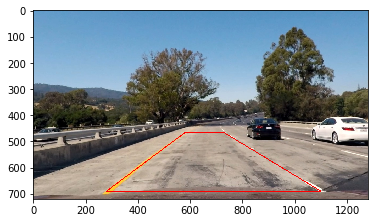

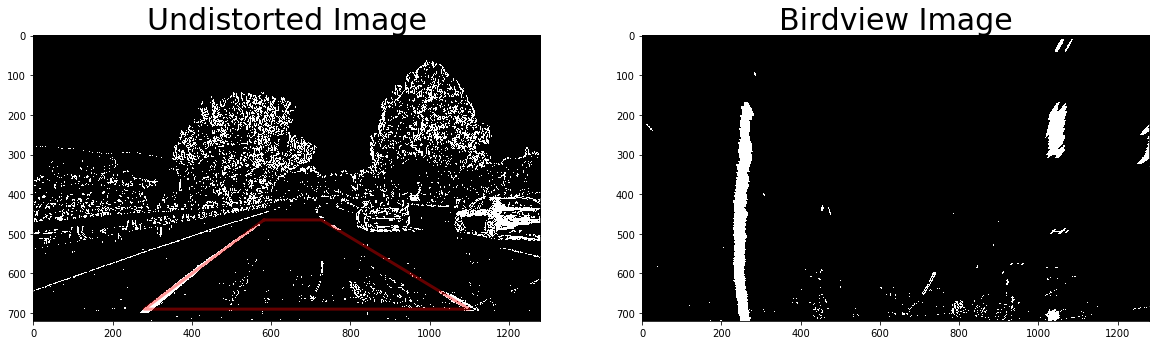

In [62]:
### Warp images to change perspective
def get_birdview(img, src, dst):
    
    img_size = (img.shape[1], img.shape[0])

    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # save the inverse transform matrix to rectify images after processing
    M_inv = cv2.getPerspectiveTransform(dst,src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
               
    return warped, M, M_inv

src = np.float32([(582,465),
              (727,465), 
              (280,690), 
              (1100,690)])

offset = 250
dst = np.float32([(offset,0),
              (undist_img.shape[1]-offset,0),
              (offset,undist_img.shape[0]),
              (undist_img.shape[1]-offset,undist_img.shape[0])])

birdview_img, M, Minv = get_birdview(binary_img, src, dst)
### Save the original image with region of interests plotted
roi_img = np.copy(undist_img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
cv2.line(roi_img, (x[0], y[0]), (x[1], y[1]), [255,0, 0], thickness=2)
cv2.line(roi_img, (x[1], y[1]), (x[2], y[2]), [255,0, 0], thickness=2)
cv2.line(roi_img, (x[2], y[2]), (x[3], y[3]), [255,0, 0], thickness=2)
cv2.line(roi_img, (x[0], y[0]), (x[3], y[3]), [255,0, 0], thickness=2)
cv2.imwrite('output_images/'+fname+'_src_roi.jpg', bgr2rgb(roi_img))

plt.imshow(roi_img)
## Save the output birdview image
cv2.imwrite('output_images/'+fname+'_birdview.jpg', normalize_binary_img(birdview_img))

# Visualize birdview image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_img, cmap='gray')
ax1.plot(x, y, color='#FF0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(birdview_img, cmap='gray')
ax2.set_title('Birdview Image', fontsize=30)

#### 4. Classifing lane lines, and fitting their positions
**Criteria**
Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

**Specifications**
Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

**Implementation**
After obtaining the birdview image, the next step is to identify the pixels belonging to each of the left and the right lines of the lane. This is done using histogram function for vertical pixels in the binary birdview image. In the image, two histogram peaks should be identified. These peaks imply the lane line. The classification of pixels whether they belong to left or right lane lines, is done by splitting the image to two halves.

Using a sliding window approach, the lane lines are splitted to n number of windows to identify the original region to have meaningful lane markings. After classification of the markings to each side of the lane, and using the sliding windows, a polynomial fitting curve function is performed to identify the line curvature.

True

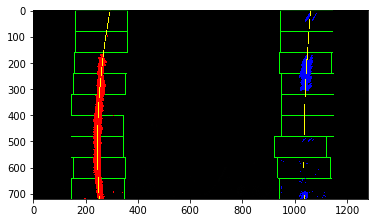

In [63]:
def find_lane_pixels(binary_warped):
    '''
    Identifies the pixels belonging to each of the left and right lane lines based on the histogram
    calculation of the pixels per warped binary image columns (vertical histogram)
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
           (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds


def fit_sliding_window(binary_warped, visualize=True):
    '''
    Classifies the lines to different sliding windows, and finds the lane pixels in those sliding windows
    then, a fitted curve is calculated on those classified pixels in each side of the lane
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    if visualize == True:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        int_ploty = ploty.astype(int)
        int_leftx = left_fitx.astype(int)
        int_rightx = right_fitx.astype(int)
        i = 1
        while(i < len(ploty)):
            cv2.line(out_img, (int_leftx[i-1], int_ploty[i-1]), (int_leftx[i], int_ploty[i]), [255,255,0], thickness=2)
            cv2.line(out_img, (int_rightx[i-1], int_ploty[i-1]), (int_rightx[i], int_ploty[i]), [255,255,0], thickness=2)
            i += 1


        return ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, left_lane_inds, right_lane_inds
    else:
        return ploty, left_fit, left_fitx, right_fit, right_fitx, None, left_lane_inds, right_lane_inds

ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, left_lane_inds, right_lane_inds = fit_sliding_window(birdview_img)

# Plots the left and right polynomials on the lane lines
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
cv2.imwrite('output_images/'+fname+'_classifiedlanes.jpg', bgr2rgb(out_img))

#### 5. Calculation for radius of curvature

**Criteria**
Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

**Specifications**
Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

**Implementation**
Given the left fit and right fit for the lane lines, the curvature of the road can be calculated by finding the result of the equation:  ((1+(2Ay+B)^2 )^3/2) / |2A| . After that, the resulting pixels are converted to meters.
Then, to identfy the center of the image, assuming the camera to be mounted on the center of the vehicle, the mid point of the lane is identified and the difference from the center of the image is used to find the offset from the middle of the lane.

In [64]:
def measure_curvature_real(bin_img, ploty, left_fit, left_fitx, right_fit, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters given left and right polynomial fits.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    #  ((1+(2Ay+B)^2 )^3/2) / |2A|
    right_curverad =  ((1+((2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2))**(3/2))/np.abs(2*right_fit_cr[0])  ## Implement the calculation of the left line here
    left_curverad = ((1+((2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2))**(3/2))/np.abs(2*left_fit_cr[0])  ## Implement the calculation of the right line here
    
    img_size = (bin_img.shape[1], bin_img.shape[0])
    if right_fit_cr is not None and left_fit_cr is not None:
        car_position = img_size[0]/2
        l_fit_x = left_fit[0]*img_size[0]**2 + left_fit[1]*img_size[0] + left_fit[2]
        r_fit_x = right_fit[0]*img_size[0]**2 + right_fit[1]*img_size[0] + right_fit[2]
        lane_center_position = (r_fit_x + l_fit_x) /2
        center_offset = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_offset
    
# Calculate the radius of curvature in pixels for both lane lines
left_curve_rad, right_curve_rad, center_offset = measure_curvature_real(binary_img, ploty, left_fit, left_fitx, right_fit, right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_str = "Radius of curvature: %.2f m" % average_curve_rad
offset_center_str = "Distance from lane center for example: %.2f m" % center_offset
print('left curvrad: ' , left_curve_rad, ' right curvrad: ', right_curve_rad)
print(curvature_str)
print(offset_center_str)


left curvrad:  1057.15669282  right curvrad:  2515.79241762
Radius of curvature: 1786.47 m
Distance from lane center for example: -0.32 m


#### 6. Warping images to original perspective

**Criteria**
Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

**Specifications**
The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

**Implementation**
After finishing all calculations of lanes, and their data. It is time to reqtify image back to original perspective. This is done by calling warpPerspective again but with the inverse transformation matrix. The newly fitted lines are drawn on a blank warped image, then unwarped using the same inverse matrix. Last step is to overlay the lane lines on the original undistorted image.

True

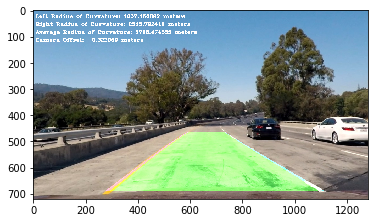

In [65]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    '''
    Warps the image back to the original perspective using inverse Matrix
    and
    Draws the lane lines on the original perspective image given the left and right polynomial fits
    '''
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_img.shape[0]-1, num=binary_img.shape[0])# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_img.shape[1], binary_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

def write_data(img, left_curve_rad, right_curve_rad, center_offset):
    '''
    Writes the curvature and offset of the camera from the center of the lane on the image
    '''
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Left Radius of Curvature: {0:6f} meters'.format(left_curve_rad), (10,30), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Right Radius of Curvature: {0:6f} meters'.format(right_curve_rad),(10,60), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Average Radius of Curvature: {0:6f} meters'.format(average_curve_rad),(10,90), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(center_offset), (10,120), font, 1, (255,255,255), 2)

final_image = draw_lane(undist_img, binary_img, left_fit, right_fit, Minv)
write_data(final_image, left_curve_rad, right_curve_rad, center_offset)
plt.imshow(final_image)

cv2.imwrite('output_images/'+fname+'_final_image.jpg', bgr2rgb(final_image))

#### Reading from prior frames curve fitting...
**Explanation**
This function is used in case of having consequetive frames (or processed in a video), where we do not need to apply the sliding window polynomial fitting every frame. Since it is known that the change in lane positions between frames do not change dramatically. So, for optimization, a search region is identified around the previously identified polynomial fit. If this region has the lane pixels, then the classification is done faster.

In [10]:
### Finding the Lines: Search from Prior
# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, visualize=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    if visualize==True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        int_ploty = ploty.astype(int)
        int_leftx = left_fitx.astype(int)
        int_rightx = right_fitx.astype(int)
        i = 1
        while(i < len(ploty)):
            cv2.line(result, (int_leftx[i-1], int_ploty[i-1]), (int_leftx[i], int_ploty[i]), [255,255,0], thickness=2)
            cv2.line(result, (int_rightx[i-1], int_ploty[i-1]), (int_rightx[i], int_ploty[i]), [255,255,0], thickness=2)
            i += 1
            
        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if visualize == True:
        return ploty, left_fit_new, left_fitx, right_fit_new, right_fitx, left_lane_inds, right_lane_inds, result
    else:
        return ploty, left_fit_new, left_fitx, right_fit_new, right_fitx, left_lane_inds, right_lane_inds, None


Having test 4 processed, gives the chance to consider test5.jpg then test6.jpg as consequtive images to test our search_around_poly function...

Text(0.5,1,'Final Image')

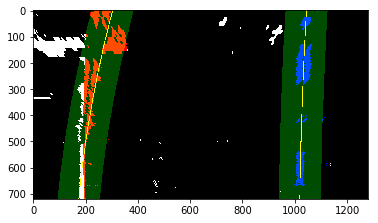

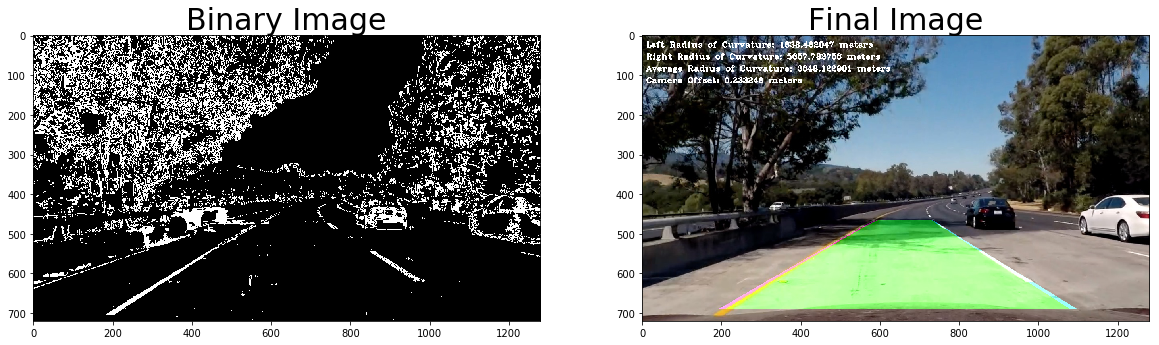

In [11]:
#Test the prior frame calculation on test5 which can be considered as next frame for test4
new_test_img = mpimg.imread('test_images/test5.jpg')
new_undist_img = cv2.undistort(new_test_img, mtx, dist, None, mtx)
new_binary_img = transform_img_to_binary(new_undist_img, sobel_kernel=15)

new_src = np.float32([(582,465),
              (727,465), 
              (280,690), 
              (1100,690)])

offset = 250
new_dst = np.float32([(offset,0),
              (new_undist_img.shape[1]-offset,0),
              (offset,new_undist_img.shape[0]),
              (new_undist_img.shape[1]-offset,new_undist_img.shape[0])])

new_birdview_img, new_M, new_Minv = get_birdview(new_binary_img, new_src, new_dst)

new_ploty, new_left_fit, new_left_fitx, new_right_fit, new_right_fitx, new_left_lane_inds, new_right_lane_inds, new_out_img = search_around_poly(
    new_birdview_img, left_fit, right_fit, True)
new_left_curve_rad, new_right_curve_rad, new_center_offset = measure_curvature_real(new_binary_img,
                                                                        new_ploty,
                                                                        new_left_fit,
                                                                        new_left_fitx,
                                                                        new_right_fit,
                                                                        new_right_fitx)
new_final_image = draw_lane(new_undist_img, new_binary_img, new_left_fit, new_right_fit, new_Minv)
write_data(new_final_image, new_left_curve_rad, new_right_curve_rad, new_center_offset)
cv2.imwrite('output_images/test5_fromPrior_final.jpg', bgr2rgb(new_final_image))
cv2.imwrite('output_images/test5_fromPrior_birdview.jpg', bgr2rgb(new_out_img))

plt.imshow(new_out_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(new_binary_img, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(new_final_image)
ax2.set_title('Final Image', fontsize=30)
 

Text(0.5,1,'Final Image')

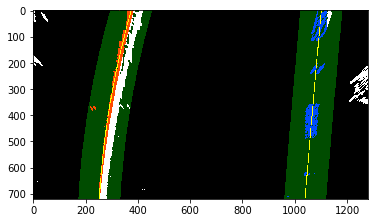

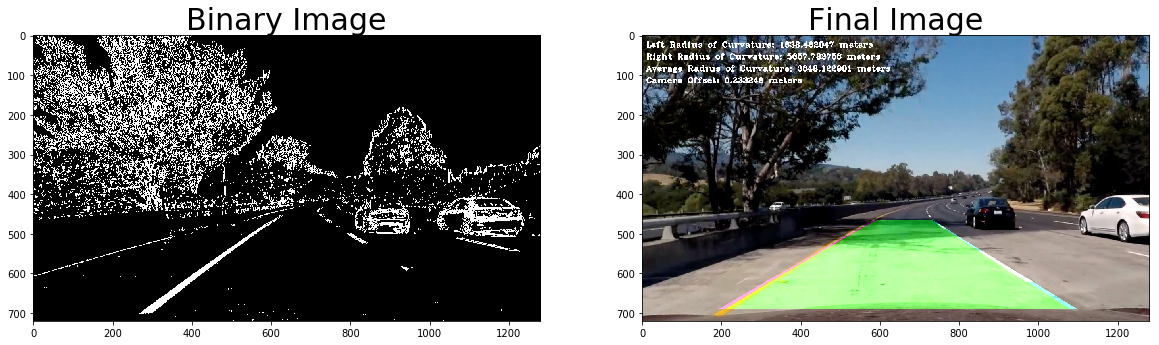

In [12]:
#Repeat same test for test 6 which is the next frame for test 5
new2_test_img = mpimg.imread('test_images/test6.jpg')
new2_undist_img = cv2.undistort(new2_test_img, mtx, dist, None, mtx)
new2_binary_img = transform_img_to_binary(new2_undist_img, sobel_kernel=15)
    
src = np.float32([(582,465),
              (727,465), 
              (280,690), 
              (1100,690)])

offset = 250
dst = np.float32([(offset,0),
              (new2_undist_img.shape[1]-offset,0),
              (offset,new2_undist_img.shape[0]),
              (new2_undist_img.shape[1]-offset,new2_undist_img.shape[0])])


new2_birdview_img, new2_M, new2_Minv = get_birdview(new2_binary_img, src, dst)

new2_ploty, new2_left_fit, new2_left_fitx, new2_right_fit, new2_right_fitx, new2_left_lane_inds, new2_right_lane_inds, new2_out_img = search_around_poly(
    new2_birdview_img, new_left_fit, new_right_fit, True)
new2_left_curve_rad, new2_right_curve_rad, new2_center_offset = measure_curvature_real(new2_binary_img,
                                                                        new2_ploty,
                                                                        new2_left_fit,
                                                                        new2_left_fitx,
                                                                        new2_right_fit,
                                                                        new2_right_fitx)
new2_final_image = draw_lane(new2_undist_img, new2_binary_img, new2_left_fit, new2_right_fit, new2_Minv)
write_data(new2_final_image, new2_left_curve_rad, new2_right_curve_rad, new2_center_offset)
cv2.imwrite('output_images/test6_fromPrior_final.jpg', bgr2rgb(new2_final_image))
cv2.imwrite('output_images/test6_fromPrior_birdview.jpg', bgr2rgb(new2_out_img))

plt.imshow(new2_out_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(new2_binary_img, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(new_final_image)
ax2.set_title('Final Image', fontsize=30)

### Pipeline Video

**Criteria**
Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

**Specifications**
The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

**Implementation**
Processes each image of the video by performing the steps: undistortion, binary transformation, birdview perspective transformation, finding fitted line either using sliding windows or region from previous detection, finding lane width, curvature and offset of ego vehicle to center of the lane, and adding the detected fit to list of fitted lines. 

A class Line() is defined to carry and processes some common attributes for lane lines such as: best_fit, last_fit and last valid n detections.


In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # last valid fit of the previous step(s)
        self.last_fit = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def add_fit(self, fit, curve_rad, lane_width):
        if lane_width >= 2.5 and lane_width <= 4.5:
            if curve_rad >= 900:
                self.last_fit = fit
                self.radius_of_curvature = curve_rad
                self.current_fit.append(fit)
                if(len(self.current_fit) >= 10):
                    self.best_fit = np.ma.average(self.current_fit, axis=0)
                    self.current_fit = self.current_fit[len(self.current_fit)-9:]
                else:
                    self.best_fit = fit
                self.detected = True
            
            elif  len(self.current_fit) < 10:
                self.best_fit = fit
                self.last_fit = fit
                self.current_fit.append(fit)
                self.detected = True
                
            else:
                self.best_fit = np.ma.average(self.current_fit, axis=0)
                self.current_fit = self.current_fit[len(self.current_fit)-9:]
                self.detected = True
        
        else:
            if len(self.last_fit) == 0:
                self.best_fit = fit
                self.last_fit = fit
            else:
                self.best_fit = self.last_fit
            self.detected = False


In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def find_lane_width(right_fitx, left_fitx):
    '''
    Calculates the width of the lane in meters given the left and right fit x pixels
    It gets the difference between lines on each row of the image, and returns average difference in meters
    '''
    diff = 0
    for i in range(len(right_fitx)):
        diff += right_fitx[i] - left_fitx[i]

    diff = diff/len(right_fitx)
    diff_m = diff*3.7/800
    return diff_m

def pipeline_image(input_image):
    '''
    Processes each image of the video by performing the steps: undistortion, binary transformation, birdview 
    perspective transformation, finding fitted line either using sliding windows or region from previous detection, 
    finding lane width, curvature and offset of ego vehicle to center of the lane, and adding the detected fit to list
    of fitted lines. 
    '''
    new_img = np.copy(input_image)
    h,w = new_img.shape[1], new_img.shape[0]
    
    undist_img = cv2.undistort(new_img, mtx, dist, None, mtx)
    binary_img = transform_img_to_binary(undist_img, sobel_kernel=15)
    
    src =  np.float32([(582,465),
              (727,465), 
              (280,690), 
              (1100,690)])

    offset = 250
    dst = np.float32([(offset,0),
                  (undist_img.shape[1]-offset,0),
                  (offset,undist_img.shape[0]),
                  (undist_img.shape[1]-offset,undist_img.shape[0])])

    birdview_img, M, Minv = get_birdview(binary_img, src, dst)
    
    # if both left and right lines were detected last frame, use search_around_poly, otherwise use sliding window
    if left_line.detected == False or right_line.detected == False:
        #print("here 1")
        ploty, left_fit, left_fitx, right_fit, right_fitx, out_img, left_lane_inds, right_lane_inds = fit_sliding_window(
            birdview_img, False)

    else:
        #print("here 2")
        ploty, left_fit, left_fitx, right_fit, right_fitx, left_lane_inds, right_lane_inds, out_img = search_around_poly(birdview_img,
                                                                            left_line.best_fit,
                                                                            right_line.best_fit, 
                                                                            False)
    
    left_curve_rad, right_curve_rad, center_offset = measure_curvature_real(binary_img,
                                                                            ploty,
                                                                            left_fit,
                                                                            left_fitx,
                                                                            right_fit,
                                                                            right_fitx) 
    #print("left: ", left_curve_rad, "right: ", right_curve_rad)
    
    lane_width = find_lane_width(right_fitx, left_fitx)
    left_line.add_fit(left_fit, left_curve_rad, lane_width)
    right_line.add_fit(right_fit, right_curve_rad, lane_width)
    
    final_image = draw_lane(undist_img, binary_img, left_line.best_fit, right_line.best_fit, Minv)
    write_data(final_image, left_curve_rad, right_curve_rad, center_offset)
    return final_image


In [16]:
# Calibrate the camera before starting any pipeline functions
mtx, dist = calibrate_camera()
left_line = Line()
right_line = Line()

project_output = 'project_video_output.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip('./project_video.mp4')#.subclip(0,5)
project_clip = clip1.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:13<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 30s, sys: 33 s, total: 4min 3s
Wall time: 6min 16s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

#### Challenge Video

In [32]:
challenging_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('./challenge_video.mp4')#.subclip(0,5)
challenge_clip = clip2.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenging_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:19<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 18s, sys: 12.4 s, total: 1min 31s
Wall time: 2min 22s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenging_output))

#### Harder Challenge Video...


In [34]:
harder_challenging_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip('./harder_challenge_video.mp4')#.subclip(0,5)
harder_challenge_clip = clip3.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenging_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:40<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 35s, sys: 28 s, total: 4min 3s
Wall time: 6min 45s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenging_output))